In [1]:
import os
import gym
import numpy as np
import pickle
from livelossplot import PlotLosses
from collections import deque

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from graph_envs.GraphEnv.impnode import ImpnodeEnv

In [1]:
import DQN_agent

In [15]:
# create an "image" that will be used to render the interaction of the agent with the environmet
# when render is set to False, return no "image"

def get_display_screen(env, render):
    env.reset()
    if not render:
        return None
    return plt.imshow(env.render(mode='rgb_array'))

In [16]:
# update the "image" to display the current environment-agent interaction

def render_env(env, display_screen):
    display_screen.set_data(env.render(mode='rgb_array')) # update the data
    display.display(plt.gcf()) # feed current figure to display
    display.clear_output(wait=True)

In [17]:
# sets the provided seed value for all components with random value generation

def set_seeds(env, seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    #env.seed(seed)
    env.action_space.np_random.seed(seed)

In [18]:
# to initialize the replay buffer with some random interactions

def fill_memory(env, agent):
    for _ in range(NUM_MEM_FILL_EPS):
        done = False
        state, info = env.reset()

        while not done:
            action = env.action_space.sample() # samples random action
            next_state, reward, done, truncated, info = env.step(action)
            agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)

In [19]:
# trains the agent and plots the associated moving average rewards and epsilon values in real-time

def train_loop(env, agent, display_screen, results_basepath):

    liveloss = PlotLosses()
    logs = {}

    last_100_rewards = deque([], maxlen=100)

    reward_history = []
    epsilon_history = []

    step_cnt = 0
    best_score = -np.inf

    for ep_cnt in range(NUM_TRAIN_EPS):

        logs['train epsilon'] = agent.epsilon # to plot current epsilon value

        done = False
        state, info = env.reset()

        ep_score = 0

        while not done:
            # if display is available, then render the interaction
            if display_screen is not None:
                render_env(env=env, display_screen=display_screen)

            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)

            agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)
            agent.learn(BATCHSIZE)

            if step_cnt % UPDATE_FREQUENCY == 0:
                agent.update_target_net()

            state = next_state
            ep_score += reward
            step_cnt += 1

        agent.update_epsilon()

        last_100_rewards.append(ep_score)
        current_avg_score = np.mean(last_100_rewards) # get average of last 100 scores
        logs['train avg score'] = current_avg_score

        # reward and epsilon history tracked only when running locally, otherwise runs into memory issues with binder

        reward_history.append(ep_score)
        epsilon_history.append(logs['train epsilon'])

        if current_avg_score >= best_score:
            agent.save_model('{}/dqn_model'.format(results_basepath))
            best_score = current_avg_score

        # update the plots in real-time
        liveloss.update(logs)
        liveloss.send()

    # store the reward and epsilon history that was tracked while running locally

    with open('{}/train_reward_history.pkl'.format(results_basepath), 'wb') as f:
        pickle.dump(reward_history, f)

    with open('{}/train_epsilon_history.pkl'.format(results_basepath), 'wb') as f:
        pickle.dump(epsilon_history, f)

In [20]:
## variables for training the agent

ENV_NAME_TRAIN = 'ImpnodeEnv'#'MountainCar-v0' ## tested on: CartPole-v0, MountainCar-v0, LunarLander-v2
RENDER_TRAIN = False ## whether to render the interaction while training

NUM_TRAIN_EPS = 10 #1000 ## number training episodes to run
NUM_MEM_FILL_EPS = 5 #10 ## number of episodes to run to initialize the memory

DISCOUNT = 0.99 ## gamma used for computing return
BATCHSIZE = 64 ## number of transitions to sample from replay buffer for each learn step
MEMORY_CAPACITY = 50 ## size of the memory buffer
UPDATE_FREQUENCY = 10 ## number of interactions after which the target buffer is updated

EPS_MAX = 1.0 ## initial epsilon value
EPS_MIN = 0.8 ## final epsilon value
EPS_DECAY = 0.5 ## amount by which epsilon is decayed at each episode

LR = 0.1 ## learning rate for the network

TRAIN_SEED = 12321

In [21]:
# create folder for storing the model and other files
results_basepath_train = "results/{}_epsmax{}_epsmin{}_epsdec{}_batchsize{}_treps{}_memeps{}".format(
                                                                                                ENV_NAME_TRAIN,
                                                                                                EPS_MAX,
                                                                                                EPS_MIN,
                                                                                                EPS_DECAY,
                                                                                                BATCHSIZE,
                                                                                                NUM_TRAIN_EPS,
                                                                                                NUM_MEM_FILL_EPS)
os.makedirs(results_basepath_train, exist_ok=True)

# create environment and set associated seeds
#env_train = gym.make(ENV_NAME_TRAIN)
#set_seeds(env_train, TRAIN_SEED)

seed = 5545
env_train = ImpnodeEnv(8, 2, 3, seed)



In [22]:
# create the dqn_agent
dqn_agent_train = DQN_agent.DQNAgent(device,
                                     env_train.observation_space.shape[0],
                                     env_train.action_space.n,
                                     discount=DISCOUNT,
                                     eps_max=EPS_MAX,
                                     eps_min=EPS_MIN,
                                     eps_decay=EPS_DECAY,
                                     memory_capacity=MEMORY_CAPACITY,
                                     lr=LR,
                                     train_mode=True)

# get screen to display on based on whether rendering is required
display_screen_train = get_display_screen(env_train, RENDER_TRAIN)

NameError: name 'DQNAgent' is not defined

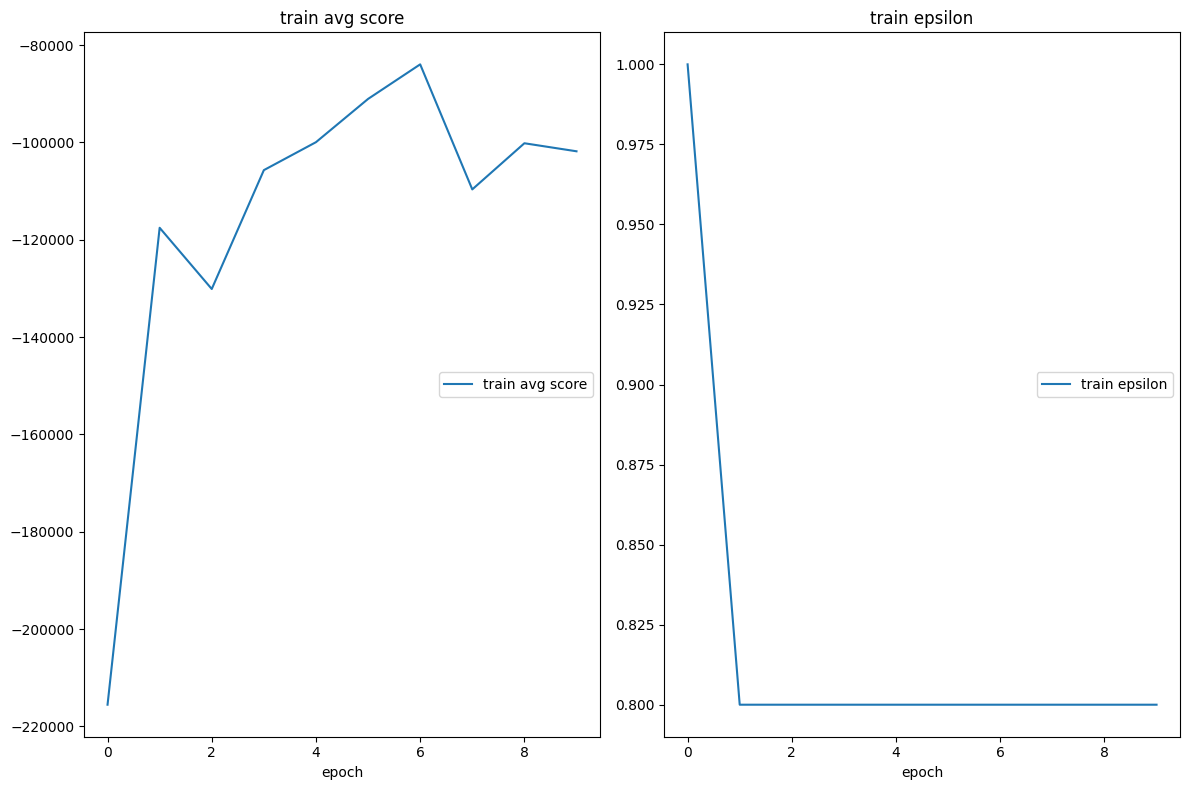

train avg score
	train avg score  	 (min: -215539.000, max: -83942.857, cur: -101809.400)
train epsilon
	train epsilon    	 (min:    0.800, max:    1.000, cur:    0.800)


In [299]:
# initialise the memory
fill_memory(env_train, dqn_agent_train)

# train the agent
train_loop(env_train, dqn_agent_train, display_screen_train, results_basepath_train)

In [300]:
# tests the agent through interactions with the environment and plots the associated rewards in real-time

def test_loop(env, agent, display_screen, results_basepath):
    liveloss = PlotLosses()
    logs = {}

    reward_history = []

    for ep in range(NUM_TEST_EPS):
        ep_score = 0
        done = False
        state, info = env.reset()
        while not done:
            # if display is available, render the interaction
            if display_screen is not None:
                render_env(env=env, display_screen=display_screen)

            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            ep_score += reward
            state = next_state

        # track reward history only while running locally

        reward_history.append(ep_score)

        # update the plot in real-time
        logs['test score'] = ep_score
        liveloss.update(logs)
        liveloss.send()

    # store the reward that was tracked while running locally

    with open('{}/test_reward_history_{}.pkl'.format(results_basepath, TEST_SEED), 'wb') as f:
        pickle.dump(reward_history, f)

In [301]:
## variables for testing the agent

# location where the model is stored and the name of the associated environment
#RESULTS_BASEPATH_TEST = 'results/CartPole-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64_treps10_memeps5'
#ENV_NAME_TEST = 'CartPole-v0'

#RESULTS_BASEPATH_TEST = 'pretrained/LunarLander-v2_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64'
#ENV_NAME_TEST = 'LunarLander-v2'

RESULTS_BASEPATH_TEST = 'pretrained/MountainCar-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64'
ENV_NAME_TEST = 'MountainCar-v0'

#RESULTS_BASEPATH_TEST = 'pretrained/CartPole-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64'
#ENV_NAME_TEST = 'CartPole-v0'

RENDER_TEST = False ## whether to render the interaction while testing

NUM_TEST_EPS = 10 ## number of test episodes to run

TEST_SEED = 456
#TEST_SEED = [456, 12, 985234, 123, 3202]

In [302]:
# create test environment and set associated seeds
env_test = gym.make(ENV_NAME_TEST)
#set_seeds(env_test, TEST_SEED)

# create the dqn agent with the stored weights
dqn_agent_test = DQNAgent(device=device,
                          state_size=env_test.observation_space.shape[0],
                          action_size=env_test.action_space.n,
                          discount=0.0,
                          eps_max=0.0,
                          eps_min=0.0,
                          eps_decay=0.0,
                          memory_capacity=0,
                          train_mode=False)
dqn_agent_test.load_model('{}/dqn_model'.format(RESULTS_BASEPATH_TEST))

# get screen to display on based on whether rendering is required
display_screen_test = get_display_screen(env_test, RENDER_TEST)

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained/MountainCar-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64/dqn_model'

In [ ]:
# test the agent

test_loop(env=env_test,
          agent=dqn_agent_test,
          display_screen=display_screen_test,
          results_basepath=RESULTS_BASEPATH_TEST)

In [ ]:
# testing the rendering of the environment with a single episode as it is extremely slow

display_screen_render = get_display_screen(env_test, True)
NUM_TEST_EPS = 1

test_loop(env=env_test,
          agent=dqn_agent_test,
          display_screen=display_screen_render,
          results_basepath=RESULTS_BASEPATH_TEST)